<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/simulations/DNRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/GNNs/')
from functions import *
from dnri import DNRI

In [3]:
#Import Functions

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import random
from torch.utils.data import Dataset
import argparse, os, time
from torch.nn import init
import math
import networkx as nx
import pandas as pd

Parameters

In [4]:
params = {}
tau = 1
params['test_burn_in_steps'] =0
params['num_time_steps'] = 50
params['data_path']= '/content/MyDrive/GNNs'
params['num_train'] = 6000
params['num_val'] = 2000
params['num_test']= 2000
params['load_model'] = False
params['load_best_model'] = False
params['model_type'] = 'dnri'
#params['graph_type'] = ['static', 'dynamic']
params['graph_type'] = 'dynamic'
params['encoder_no_factor'] = True
params['num_epochs'] = 100
params['num_vars'] = params['num_agents'] = 10
params['input_noise_type'] = 'none'
params['input_size'] = 4
params['nll_loss_type'] = 'gaussian'
params['prior_variance'] = 5e-5
params['batch_size'] = 64
params['val_batch_size'] = 64
params['accumulate_steps'] = 40
params['num_edge_types'] = 2
params['encoder_dropout'] = 0.5
params['encoder_hidden'] = 256
params['encoder_rnn_hidden'] = 64
params['encoder_rnn_type'] = 'lstm'
params['encoder_mlp_num_layers'] = 1
params['encoder_mlp_hidden'] = 256
params['prior_num_layers'] = 1
params['prior_hidden_size'] = 256
params['gpu'] = False
params['decoder_hidden'] = 256
params['skip_first'] = False
params['decoder_dropout'] = 0.5
params['decoder_type'] = None
params['lr'] = 5e-4
params['mode'] = "train"

params['working_dir'] =params['output_dir'] =  ('/content/MyDrive/GNNs')

Dataset

In [5]:
df = pd.read_pickle("/content/drive/MyDrive/GNNs/boids_buffer_10_v3.csv")

In [6]:
df.shape

(10000, 4)

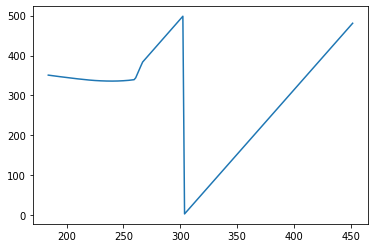

In [16]:
x = []
y = []

for i in range(150):
  x.append(df.iloc[i].trajectory[1][0])
  y.append(df.iloc[i].trajectory[1][1])

%matplotlib inline
plt.plot(x,y)
plt.show()

In [95]:
df.head()

,R,theta,velocity,trajectory
0,"[[104.03759, 290.2829], [451.4676, 480.8318], ...","[3.8226228, 4.4124546, 1.4677178, 4.980793, 5....","[[-3.8846226, -3.1479688], [-1.4772882, -4.776...","[[104.03759, 290.2829, -3.8846226, -3.1479688]..."
1,"[[100.15297, 287.13492], [449.9903, 476.05502]...","[3.8226228, 4.4124546, 1.4677178, 4.980793, 5....","[[-3.8846226, -3.1479688], [-1.4772882, -4.776...","[[100.15297, 287.13492, -3.8846226, -3.1479688..."
2,"[[96.26835, 283.98694], [448.51303, 471.27823]...","[3.8226228, 4.4124546, 1.4677178, 4.980793, 5....","[[-3.8846226, -3.1479688], [-1.4772882, -4.776...","[[96.26835, 283.98694, -3.8846226, -3.1479688]..."
3,"[[92.38372, 280.839], [447.03574, 466.50146], ...","[3.8226228, 4.4124546, 1.4677178, 4.980793, 5....","[[-3.8846226, -3.1479688], [-1.4772882, -4.776...","[[92.38372, 280.839, -3.8846226, -3.1479688], ..."
4,"[[88.4991, 277.691], [445.55844, 461.72467], [...","[3.8226228, 4.4124546, 1.4677178, 4.980793, 5....","[[-3.8846226, -3.1479688], [-1.4772882, -4.776...","[[88.4991, 277.691, -3.8846226, -3.1479688], [..."


In [96]:
data = []
for w in range(len(df)):
  
  state = np.array(df.R[w])
  D = list()
  for a,i in enumerate(state):
    d= []
    for b,j in enumerate(state):
      eDistance = math.hypot(i[0] - j[0], i[1] - j[1])
      if a == b:
        d.append(0)
      elif int(eDistance) <= 45:
        d.append(1)
      else:
        d.append(0)
    D.append(d)

  data.append(np.array(D))
edge_data = np.array(data)
all_data = np.array(list(df.trajectory))

adj_array = []
#print(edge_data.shape)
for time_step in range(len(edge_data)):
  edge = []
  for i in range(len(edge_data[0])):
    edge = edge + list(list(edge_data[time_step][i][:i])+list(edge_data[time_step][i][i+1:]))
    
  #print(len(edge[0].shape))
  adj_array.append(edge)

edge_data = np.array(adj_array)

In [97]:
all_data = np.stack(all_data)
train_data = torch.FloatTensor(all_data[:params['num_train']])
val_data = torch.FloatTensor(all_data[params['num_train']:params['num_train']+params['num_val']])
test_data = torch.FloatTensor(all_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

train_edges = torch.FloatTensor(edge_data[:params['num_train']])
val_edges = torch.FloatTensor(edge_data[params['num_train']:params['num_train']+params['num_val']])
test_edges = torch.FloatTensor(edge_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

In [98]:
del all_data, df,edge_data, data

In [99]:
print("Train Shape:", train_data.shape,"\n", 
       "Val Shape:", val_data.shape,"\n",
      "Test Shape:", test_data.shape)

Train Shape: torch.Size([6000, 10, 4]) 
 Val Shape: torch.Size([2000, 10, 4]) 
 Test Shape: torch.Size([2000, 10, 4])


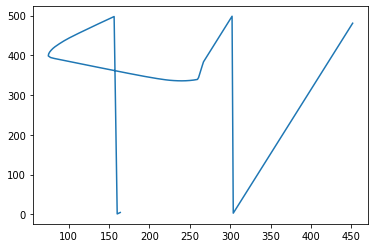

In [104]:
x = []
y = []
for time_step in range(200):
  x.append(train_data[time_step][1][0])
  y.append(train_data[time_step][1][1])

%matplotlib inline
plt.plot(x,y)
plt.show()

In [84]:
train_data = train_data.reshape([int(params["num_train"]/50),50,10,4])
val_data = val_data.reshape([int(params["num_val"]/50),50,10,4])
test_data = test_data.reshape([int(params["num_test"]/50),50,10,4])

train_edges = train_edges.reshape([int(params['num_train']/50),50,90])
val_edges = val_edges.reshape([int(params['num_val']/50),50,90])
test_edges = test_edges.reshape([int(params['num_test']/50),50,90])

In [ ]:
x = []
y = []
for time_step in range(len(train_data[0])):
  x.append(train_data[0][time_step][1][0])
  y.append(train_data[0][time_step][1][1])

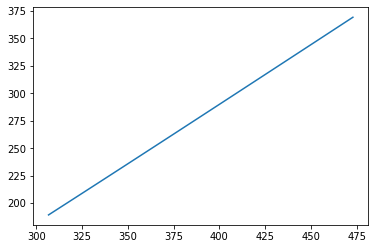

In [88]:
%matplotlib inline
plt.plot(x,y)
plt.show()

In [24]:
train_data = torch.nn.functional.normalize(train_data)
val_data = torch.nn.functional.normalize(val_data)
test_data = torch.nn.functional.normalize(test_data)

In [55]:
for epoch in range(len(train_data)):
  x = []
  y = []
  for time_step in range(len(train_data[0])):
    x.append(train_data[epoch][time_step][0][0])
    y.append(train_data[epoch][time_step][0][1])

In [58]:
%matplotlib inline
plt.plot(x,y)
plt.show()

In [ ]:
vvv

In [25]:
DATA = []

for i in range(train_data.shape[0]):
  DATA.append({'inputs':train_data[i].reshape([1,50,10,4]),'edges':train_edges[i].reshape([1,50,90])})

VAL = []

for i in range(val_data.shape[0]):
  VAL.append({'inputs':val_data[i].reshape([1,50,10,4]),'edges':val_edges[i].reshape([1,50,90])})

TEST = []

for i in range(test_data.shape[0]):
  TEST.append({'inputs':test_data[i].reshape([1,50,10,4]),'edges':test_edges[i].reshape([1,50,90])})

DNRI

Build Model

In [ ]:
def build_model(params):
    if params['model_type'] == 'dnri':
        model = DNRI(params)
        print("dNRI MODEL: ",model)
    if params['load_best_model']:
        print("LOADING BEST MODEL")
        path = os.path.join(params['working_dir'], 'best_model')
        model.load(path)
    elif params['load_model']:
        print("LOADING MODEL FROM SPECIFIED PATH")
        model.load(params['load_model'])
    if params['gpu']:
        model.cuda()
    return model

Train

In [ ]:
def train(model, train_data, val_data, params, train_writer, val_writer):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    val_batch_size = params.get('val_batch_size', batch_size)
    if val_batch_size is None:
        val_batch_size = batch_size
    accumulate_steps = params.get('accumulate_steps')
    training_scheduler = params.get('training_scheduler', None)
    num_epochs = params.get('num_epochs', 100)
    val_interval = params.get('val_interval', 1)
    val_start = params.get('val_start', 0)
    clip_grad = params.get('clip_grad', None)
    clip_grad_norm = params.get('clip_grad_norm', None)
    normalize_nll = params.get('normalize_nll', False)
    normalize_kl = params.get('normalize_kl', False)
    tune_on_nll = params.get('tune_on_nll', False)
    verbose = params.get('verbose', False)
    val_teacher_forcing = params.get('val_teacher_forcing', False)
    continue_training = params.get('continue_training', False)
    #train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    train_data_loader = DATA
    #val_data_loader = DataLoader(val_data, batch_size=val_batch_size)
    val_data_loader = VAL
    lr = params['lr']
    wd = params.get('wd', 0.1)
    mom = params.get('mom', 0.9)
    
    model_params = [param for param in model.parameters() if param.requires_grad]
    if params.get('use_adam', False):
        opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)
    else:
        opt = torch.optim.SGD(model_params, lr=lr, weight_decay=wd, momentum=mom)

    working_dir = params['working_dir']
    best_path = os.path.join(working_dir, 'best_model')
    checkpoint_dir = os.path.join(working_dir, 'model_checkpoint')
    training_path = os.path.join(working_dir, 'training_checkpoint')
    if continue_training:
        print("RESUMING TRAINING")
        model.load(checkpoint_dir)
        train_params = torch.load(training_path)
        start_epoch = train_params['epoch']
        opt.load_state_dict(train_params['optimizer'])
        best_val_result = train_params['best_val_result']
        best_val_epoch = train_params['best_val_epoch']
        print("STARTING EPOCH: ",start_epoch)
    else:
        start_epoch = 1
        best_val_epoch = -1
        best_val_result = 10000000
    
    training_scheduler = build_scheduler(opt, params)
    end = start = 0 
    #misc.seed(1)
    result = []
    for epoch in range(start_epoch, num_epochs+1):
        print("EPOCH", epoch, (end-start))
        model.train()
        model.train_percent = epoch / num_epochs
        start = time.time() 
        for batch_ind, batch in enumerate(train_data_loader):
            
            inputs = batch['inputs']
            #inputs = batch
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
            loss, loss_nll, loss_kl, logits, _ = model.calculate_loss(inputs, is_train=True, return_logits=True)
            loss.backward()
            if verbose:
                print("\tBATCH %d OF %d: %f, %f, %f"%(batch_ind+1, len(train_data_loader), loss.item(), loss_nll.mean().item(), loss_kl.mean().item()))
            if accumulate_steps == -1 or (batch_ind+1)%accumulate_steps == 0:
                if verbose and accumulate_steps > 0:
                    print("\tUPDATING WEIGHTS")
                if clip_grad is not None:
                    nn.utils.clip_grad_value_(model.parameters(), clip_grad)
                elif clip_grad_norm is not None:
                    nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)        
                opt.step()
                opt.zero_grad()
                if accumulate_steps > 0 and accumulate_steps > len(train_data_loader) - batch_ind - 1:
                    break
            
        if training_scheduler is not None:
            training_scheduler.step()
        
        if train_writer is not None:
            train_writer.add_scalar('loss', loss.item(), global_step=epoch)
            if normalize_nll:
                train_writer.add_scalar('NLL', loss_nll.mean().item(), global_step=epoch)
            else:
                train_writer.add_scalar('NLL', loss_nll.mean().item()/(inputs.size(1)*inputs.size(2)), global_step=epoch)
            
            train_writer.add_scalar("KL Divergence", loss_kl.mean().item(), global_step=epoch)
        model.eval()
        opt.zero_grad()

        total_nll = 0
        total_kl = 0
        if verbose:
            print("COMPUTING VAL LOSSES")
        with torch.no_grad():
            for batch_ind, batch in enumerate(val_data_loader):
                inputs = batch['inputs']
                if gpu:
                    inputs = inputs.cuda(non_blocking=True)
                loss, loss_nll, loss_kl, logits, _ = model.calculate_loss(inputs, is_train=False, teacher_forcing=val_teacher_forcing, return_logits=True)
                
                total_kl += loss_kl.sum().item()
                total_nll += loss_nll.sum().item()
                if verbose:
                  print("\tVAL BATCH %d of %d: %f, %f"%(batch_ind+1, len(val_data_loader), loss_nll.mean(), loss_kl.mean()))
            
        #total_kl /= len(val_data_loader)
        #total_nll /= len(val_data_loader)
        total_loss = model.kl_coef*total_kl + total_nll #TODO: this is a thing you fixed
  
        if val_writer is not None:
            val_writer.add_scalar('loss', total_loss, global_step=epoch)
            val_writer.add_scalar("NLL", total_nll, global_step=epoch)
            val_writer.add_scalar("KL Divergence", total_kl, global_step=epoch)
        if tune_on_nll:
            tuning_loss = total_nll
        else:
            tuning_loss = total_loss
        if tuning_loss < best_val_result:
            best_val_epoch = epoch
            best_val_result = tuning_loss
            print("BEST VAL RESULT. SAVING MODEL...")
            #model.save(best_path)
        model.save(checkpoint_dir)
        torch.save({
                    'epoch':epoch+1,
                    'optimizer':opt.state_dict(),
                    'best_val_result':best_val_result,
                    'best_val_epoch':best_val_epoch,
                   }, training_path)
        print("EPOCH %d EVAL: "%epoch)
        print("\tCURRENT VAL LOSS: %f"%tuning_loss)
        print("\tBEST VAL LOSS:    %f"%best_val_result)
        print("\tBEST VAL EPOCH:   %d"%best_val_epoch)
        result.append(tuning_loss)
        end = time.time()

    return result

Evaluate Forward Prediction

In [ ]:
def eval_forward_prediction(model, dataset, burn_in_steps, forward_pred_steps, params, return_total_errors=False):
    dataset.return_edges = False
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    model.eval()
    total_se = 0
    batch_count = 0
    all_errors = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            batch_count += 1
            if return_total_errors:
                all_errors.append(F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1))
            else:
                total_se += F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1).sum(dim=0)
    if return_total_errors:
        return torch.cat(all_errors, dim=0)
    else:
        return total_se / len(dataset)

def eval_forward_prediction_fixedwindow(model, dataset, burn_in_steps, forward_pred_steps, params, return_total_errors=False):
    dataset.return_edges = False
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    data_loader = DataLoader(dataset, batch_size=1)
    model.eval()
    total_se = 0
    batch_count = 0
    all_errors = []
    total_count = torch.zeros(forward_pred_steps)
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        print("BATCH IND %d OF %d"%(batch_ind+1, len(data_loader)))
        with torch.no_grad():

            if gpu:
                inputs = inputs.cuda(non_blocking=True)
            model_preds = model.predict_future_fixedwindow(inputs, burn_in_steps, forward_pred_steps, batch_size).cpu()
            for window_ind in range(model_preds.size(1)):
                current_preds = model_preds[:, window_ind]
                start_ind = burn_in_steps + window_ind
                gt_preds = inputs[:, start_ind:start_ind + forward_pred_steps].cpu()
                if gt_preds.size(1) < forward_pred_steps:
                    mask = torch.cat([torch.ones(gt_preds.size(1)), torch.zeros(forward_pred_steps - gt_preds.size(1))])
                    gt_preds = torch.cat([gt_preds, torch.zeros(gt_preds.size(0), forward_pred_steps-gt_preds.size(1), gt_preds.size(2), gt_preds.size(3))], dim=1)
                else:
                    mask = torch.ones(forward_pred_steps)
                total_se += F.mse_loss(current_preds, gt_preds, reduction='none').view(current_preds.size(0), current_preds.size(1), -1).mean(dim=-1).sum(dim=0).cpu()*mask
                total_count += mask

    return total_se / total_count


def eval_forward_prediction_dynamicvars(model, dataset, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    collate_fn = params.get('collate_fn', None)
    data_loader = DataLoader(dataset, batch_size=1, pin_memory=gpu, collate_fn=collate_fn)
    model.eval()
    total_se = 0
    batch_count = 0
    final_errors = torch.zeros(0)
    final_counts = torch.zeros(0)
    bad_count = 0
    for batch_ind, batch in enumerate(data_loader):
        print("DATA POINT ",batch_ind)
        inputs = batch['inputs']
        gt_preds = inputs[0, 1:]
        masks = batch['masks']
        node_inds = batch.get('node_inds', None)
        graph_info = batch.get('graph_info', None)
        burn_in_masks = batch['burn_in_masks']
        pred_masks = (masks.float() - burn_in_masks)[0, 1:]
        with torch.no_grad():
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
                masks = masks.cuda(non_blocking=True)
                burn_in_masks = burn_in_masks.cuda(non_blocking=True)
            model_preds = model.predict_future(inputs, masks, node_inds, graph_info, burn_in_masks)[0].cpu()
            max_len = pred_masks.sum(dim=0).max().int().item()
            if max_len > len(final_errors):
                final_errors = torch.cat([final_errors, torch.zeros(max_len - len(final_errors))])
                final_counts = torch.cat([final_counts, torch.zeros(max_len - len(final_counts))])
            for var in range(masks.size(-1)):
                var_gt = gt_preds[:, var]
                var_preds = model_preds[:, var]
                var_pred_masks = pred_masks[:, var]
                var_losses = F.mse_loss(var_preds, var_gt, reduction='none').mean(dim=-1)*var_pred_masks
                tmp_inds = torch.nonzero(var_pred_masks)
                if len(tmp_inds) == 0:
                    continue
                for i in range(len(tmp_inds)-1):
                    if tmp_inds[i+1] - tmp_inds[i] != 1:
                        bad_count += 1
                        break
                num_entries = var_pred_masks.sum().int().item()
                final_errors[:num_entries] += var_losses[tmp_inds[0].item():tmp_inds[0].item()+num_entries]
                final_counts[:num_entries] += var_pred_masks[tmp_inds[0]:tmp_inds[0]+num_entries]
    print("FINAL BAD COUNT: ",bad_count)
    return final_errors/final_counts, final_counts

In [ ]:
def eval_edges(model, dataset, params):

    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    eval_metric = params.get('eval_metric')
    num_edge_types = params['num_edge_types']
    skip_first = params['skip_first']
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    full_edge_count = 0.
    model.eval()
    correct_edges = 0.
    edge_count = 0.
    correct_0_edges = 0.
    edge_0_count = 0.
    correct_1_edges = 0.
    edge_1_count = 0.

    correct = num_predicted = num_gt = 0
    all_edges = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch['edges'].long()
        with torch.no_grad():
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
                gt_edges = gt_edges.cuda(non_blocking=True)

            _, _, _, edges, _ = model.calculate_loss(inputs, is_train=False, return_logits=True)
            edges = edges.argmax(dim=-1)
            all_edges.append(edges.cpu())
            if len(edges.shape) == 3 and len(gt_edges.shape) == 2:
                gt_edges = gt_edges.unsqueeze(1).expand(gt_edges.size(0), edges.size(1), gt_edges.size(1))
            elif len(gt_edges.shape) == 3 and len(edges.shape) == 2:
                edges = edges.unsqueeze(1).expand(edges.size(0), gt_edges.size(1), edges.size(1))
            if edges.size(1) == gt_edges.size(1) - 1:
                gt_edges = gt_edges[:, :-1]
            edge_count += edges.numel()
            full_edge_count += gt_edges.numel()
            correct_edges += ((edges == gt_edges)).sum().item()
            edge_0_count += (gt_edges == 0).sum().item()
            edge_1_count += (gt_edges == 1).sum().item()
            correct_0_edges += ((edges == gt_edges)*(gt_edges == 0)).sum().item()
            correct_1_edges += ((edges == gt_edges)*(gt_edges == 1)).sum().item()
            correct += (edges*gt_edges).sum().item()
            num_predicted += edges.sum().item()
            num_gt += gt_edges.sum().item()
    prec = correct / (num_predicted + 1e-8)
    rec = correct / (num_gt + 1e-8)
    f1 = 2*prec*rec / (prec+rec+1e-6)
    all_edges = torch.cat(all_edges)
    return f1, correct_edges / (full_edge_count + 1e-8), correct_0_edges / (edge_0_count + 1e-8), correct_1_edges / (edge_1_count + 1e-8), all_edges

def plot_sample(model, dataset, num_samples, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1)
    use_gt_edges = params.get('use_gt_edges')
    data_loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    batch_count = 0
    all_errors = []

    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch.get('edges', None)
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
                if gt_edges is not None and use_gt_edges:
                    gt_edges = gt_edges.cuda(non_blocking=True)
            if not use_gt_edges:
                gt_edges=None
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            #total_se += F.mse_loss(model_preds, gt_predictions).item()
            print("MSE: ", torch.nn.functional.mse_loss(model_preds, gt_predictions).item())
            batch_count += 1
        fig, ax = plt.subplots()
        unnormalized_preds = dataset.unnormalize(model_preds)
        unnormalized_gt = dataset.unnormalize(inputs)
        def update(frame):
            ax.clear()
            ax.plot(unnormalized_gt[0, frame, 0, 0], unnormalized_gt[0, frame, 0, 1], 'bo')
            ax.plot(unnormalized_gt[0, frame, 1, 0], unnormalized_gt[0, frame, 1, 1], 'ro')
            ax.plot(unnormalized_gt[0, frame, 2, 0], unnormalized_gt[0, frame, 2, 1], 'go')
            if frame >= params['burn_in_steps']:
                tmp_fr = frame - params['burn_in_steps']
                ax.plot(unnormalized_preds[0, tmp_fr, 0, 0], unnormalized_preds[0, tmp_fr, 0, 1], 'bo', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 1, 0], unnormalized_preds[0, tmp_fr, 1, 1], 'ro', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 2, 0], unnormalized_preds[0, tmp_fr, 2, 1], 'go', alpha=0.5)
            ax.set_xlim(-6, 6)
            ax.set_ylim(-6, 6)
        ani = animation.FuncAnimation(fig, update, interval=100, frames=params['burn_in_steps']+forward_pred_steps)
        path = os.path.join(params['working_dir'], 'pred_trajectory_%d.mp4'%batch_ind)
        ani.save(path, codec='mpeg4')
        if batch_count >= num_samples:
            break

In [ ]:
model = build_model(params)
if params['mode'] == 'train':
    with build_writers(params['working_dir']) as (train_writer, val_writer):
        result = train(model, train_data, val_data, params, train_writer, val_writer)

elif params['mode'] == 'eval':
    test_data = TEST
    forward_pred = 50 - params['test_burn_in_steps']
    test_mse  = eval_forward_prediction(model, test_data, params['test_burn_in_steps'], forward_pred, params)
    path = os.path.join(params['working_dir'], params['error_out_name']%params['test_burn_in_steps'])
    np.save(path, test_mse.cpu().numpy())
    test_mse_1 = test_mse[0].item()
    test_mse_15 = test_mse[14].item()
    test_mse_25 = test_mse[24].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ",test_mse_1)
    print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_25)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    out_dir = os.path.join(params['working_dir'], 'preds')
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'encoder_edges.npy')
    np.save(out_path, edges.numpy())

    plot_sample(model, test_data, params['test_burn_in_steps'], params)

elif params['mode'] == 'record_predictions':
    model.eval()
    burn_in = params['test_burn_in_steps']
    forward_pred = 50 - params['test_burn_in_steps']
    test_data = TEST
    if params['subject_ind'] == -1:
        val_data_loader = DataLoader(test_data, batch_size=params['batch_size'])
        all_predictions = []
        all_edges = []
        for batch_ind,batch in enumerate(val_data_loader):
            print("BATCH %d of %d"%(batch_ind+1, len(val_data_loader)))
            inputs = batch['inputs']
            if params['gpu']:
                inputs = inputs.cuda(non_blocking=True)
            with torch.no_grad():
                predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
                all_predictions.append(predictions)
                all_edges.append(edges)
        if params['error_suffix'] is not None:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects_%s.npy'%params['error_suffix'])
        else:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects.npy')

        predictions = torch.cat(all_predictions, dim=0)
        edges = torch.cat(all_edges, dim=0)

    else:
        data = test_data[params['subject_ind']]
        inputs = data['inputs'].unsqueeze(0)
        if params['gpu']:
            inputs = inputs.cuda(non_blocking=True)
        with torch.no_grad():
            predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
            predictions = predictions.squeeze(0)
            edges = edges.squeeze(0)
        out_path = os.path.join(params['working_dir'], 'preds/', 'subject_%d.npy'%args.subject_ind)
    tmp_dir = os.path.join(params['working_dir'], 'preds/')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    torch.save([predictions.cpu(), edges.cpu()], out_path)


Using learned recurrent interaction net decoder.
dNRI MODEL:  DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_fe

VGAE Jax

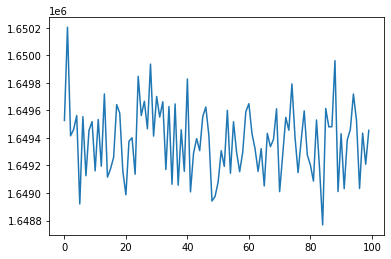

In [ ]:
plt.plot(result)